1차

In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
import glob

# 모든 파일 읽기
file_paths = glob.glob(r'C:\\Users\\kdh03\Desktop\\Labeling Data\\F*_combined.csv')
data_list = [pd.read_csv(file, header=None) for file in file_paths if 'F51' not in file]

# 데이터프레임 결합
data = pd.concat(data_list, ignore_index=True)

In [124]:
# 데이터 재구성: LSTM은 [samples, time steps, features] 형식을 기대합니다.
X = data.iloc[:, :3].values
y = data.iloc[:, 3].values

# y를 원-핫 인코딩으로 변환
y = to_categorical(y, num_classes=4)

# X를 [samples, time steps, features] 형식으로 재구성
X = X.reshape((X.shape[0], X.shape[1], 1))

# 데이터를 학습용과 테스트용으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 정보 출력
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 50)                10400     
                                                                 
 dense_29 (Dense)            (None, 4)                 204       
                                                                 
Total params: 10604 (41.42 KB)
Trainable params: 10604 (41.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [126]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
1280/9418 [===>..........................] - ETA: 11s - loss: 0.9386 - accuracy: 0.5719

KeyboardInterrupt: 

In [ ]:
# 51번째 파일 로드
test_file_path = r'C:\\Users\\kdh03\Desktop\\F51_combined.csv'
test_data = pd.read_csv(test_file_path, header=None)

# 테스트 데이터 준비
X_test_51 = test_data.iloc[:, :3].values
y_test_51 = test_data.iloc[:, 3].values

# 원-핫 인코딩으로 변환
y_test_51_categorical = to_categorical(y_test_51, num_classes=4)

# X_test_51을 [samples, time steps, features] 형식으로 재구성
X_test_51 = X_test_51.reshape((X_test_51.shape[0], X_test_51.shape[1], 1))

# 모델을 사용하여 예측 수행
y_pred_51 = model.predict(X_test_51)

# 예측 결과를 범주 값으로 변환
y_pred_classes_51 = np.argmax(y_pred_51, axis=1)

# 예측 결과 출력
print("예측 결과:", y_pred_classes_51)
print("실제 값:", y_test_51)

# 평가 지표 계산
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_51 = accuracy_score(y_test_51, y_pred_classes_51)
conf_matrix_51 = confusion_matrix(y_test_51, y_pred_classes_51)

print(f'51번째 파일의 정확도: {accuracy_51}')
print('혼동 행렬:')
print(conf_matrix_51)

623/623 [==============================] - 1s 1ms/step
예측 결과: [2 2 2 ... 2 2 2]
실제 값: [0 0 0 ... 0 0 0]
51번째 파일의 정확도: 0.7701414668405739
혼동 행렬:
[[    0     0  3425     0]
 [    0     0   755     0]
 [    0     0 15352    10]
 [    0     0   392     0]]


2차

[[0.36328772 0.35860745 0.34462677 0.        ]
 [0.36185333 0.36090248 0.34307763 0.        ]
 [0.36125089 0.35832058 0.3436227  0.        ]
 ...
 [0.49923909 0.50414001 0.50852861 0.        ]
 [0.49968916 0.50392331 0.50819523 0.        ]
 [0.49942245 0.5038733  0.50814522 0.        ]]


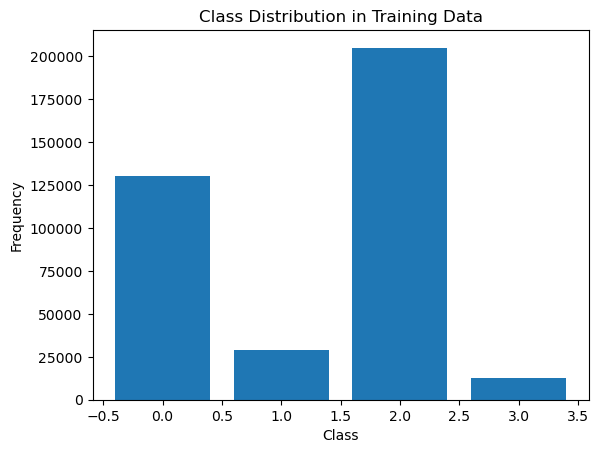

(376687, 3)


In [127]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import pickle
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리 함수
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, header=None)
    data = df.values
    return data

# 다중 타임 스텝 데이터를 생성하는 함수
def create_multistep_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

# 모든 학습 데이터 로드 및 병합
all_data = []

file_paths = [f"C:\\Users\\kdh03\\Desktop\\Labeling Data\\F{i}_combined.csv" for i in range(1, 51)]
for file_path in file_paths:
    data = load_and_preprocess(file_path)
    all_data.append(data)

all_data = np.vstack(all_data)

print(all_data)

# 데이터 분포 확인
plt.hist(all_data[:, 3], bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()

print(all_data[:, :3].shape)

In [128]:
# 다중 타임 스텝 데이터 생성
time_steps = 100  # 예시로 3개의 타임 스텝을 고려
X, y = create_multistep_data(all_data, time_steps)
y = y.astype(int)

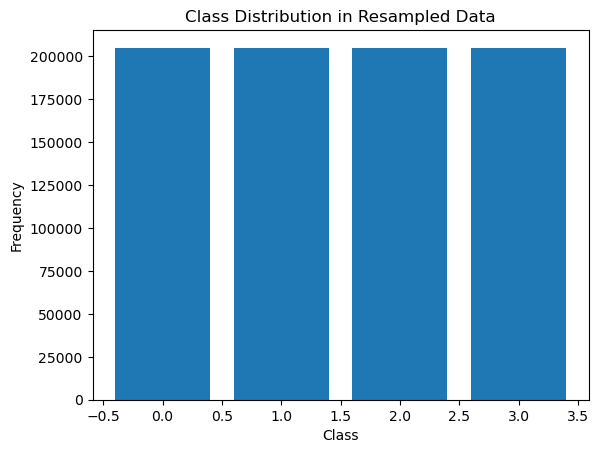

In [129]:
# 데이터 증강 (SMOTE)
smote = SMOTE()
X_reshaped = X.reshape(X.shape[0], -1)  # SMOTE를 적용하기 위해 2D 형태로 변환
X_res, y_res = smote.fit_resample(X_reshaped, y)
X_res = X_res.reshape(X_res.shape[0], time_steps, X.shape[2])  # 다시 3D 형태로 변환

# 증강된 데이터의 클래스 분포 확인
plt.hist(y_res, bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Resampled Data')
plt.show()

In [130]:
# LSTM 모델 생성 함수
def create_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(time_steps, X.shape[2])))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성 및 학습
model = create_model()
history = model.fit(X_res, y_res, epochs=100, batch_size=128, validation_split=0.2, verbose=1)

5126/5126 [==============================] - 843s 164ms/step - loss: 1.0251 - accuracy: 0.5186 - val_loss: 2.2720 - val_accuracy: 0.1288


In [131]:
# 모델 및 스케일러 저장 경로 설정
save_dir = os.path.dirname(file_paths[0])
model_save_path = os.path.join(save_dir, "lstm_model.h5")
scaler_save_path = os.path.join(save_dir, "scaler.pkl")

# 모델 저장
model.save(model_save_path)
with open(scaler_save_path, 'wb') as f:
    pickle.dump(scaler, f)

c:\Users\kdh03\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


620/620 [==============================] - 14s 22ms/step
Loss: 6.554296016693115
Accuracy: 17.37%
Confusion Matrix:
[[ 3446   734 15003   259]
 [   24     0   105   263]
 [    0     0     0     0]
 [    0     0     0     0]]


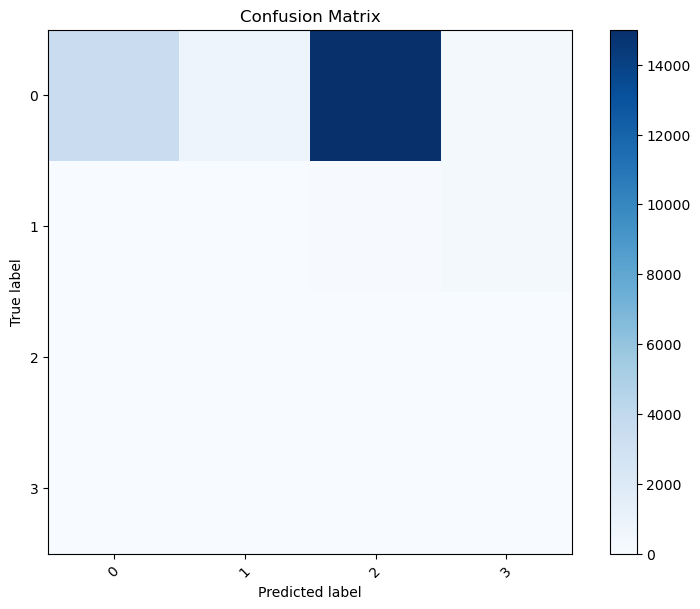

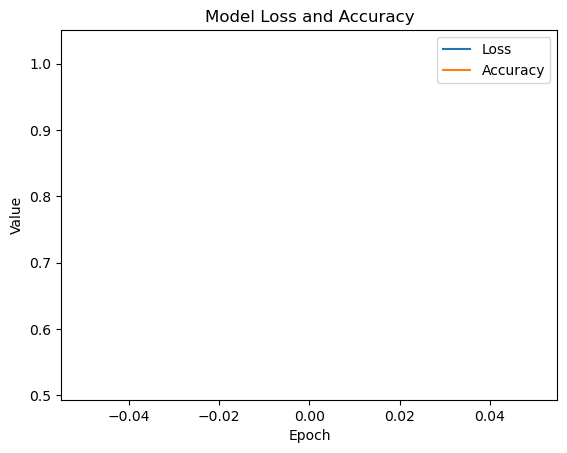

In [132]:
# 테스트 데이터 로드 및 전처리
test_file_path = "C:\\Users\\kdh03\\Desktop\\F51_combined.csv"
test_data = load_and_preprocess(test_file_path)
scaled_test_data = scaler.transform(test_data)

# 테스트 데이터도 다중 타임 스텝 데이터로 변환
X_test, y_test = create_multistep_data(scaled_test_data, time_steps)
y_test = y_test.astype(int)

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 및 정확도 계산
conf_matrix = confusion_matrix(y_test, y_pred_classes)
acc_score = accuracy_score(y_test, y_pred_classes)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, [0, 1, 2, 3], rotation=45)
plt.yticks(tick_marks, [0, 1, 2, 3])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 학습 과정의 손실 값과 정확도 출력
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Model Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()